In [21]:
SERVERS_COUNT = 10
KEYS_COUNT = 100000

In [22]:
import numpy as np

from collections.abc import Callable
from dataclasses import dataclass
from mmh3 import hash as murmurhash
from uuid import uuid4

MURMUR_SERVERS_SEED = 165233
MURMUR_KEY_SEED = 845219

In [23]:
@dataclass
class Server:
    id: str
    hash: int

def generate_server() -> Server:
    server_id = str(uuid4())
    server_hash = murmurhash(server_id, seed=MURMUR_SERVERS_SEED, signed=False)
    return Server(id=server_id, hash=server_hash)

servers = [generate_server() for _ in range(SERVERS_COUNT)]
servers

[Server(id='47609a81-5a31-40c5-a376-bfe1420bcc10', hash=544830592),
 Server(id='f4880700-90af-40f6-8a68-18f815507111', hash=2608741925),
 Server(id='51789490-df86-475b-a2aa-47e6f436f68d', hash=2223508489),
 Server(id='49605b69-6bc4-49f0-8c42-c4ca4726caff', hash=2090025153),
 Server(id='d566cace-5ca6-4630-9e47-57422fe4fce3', hash=178474108),
 Server(id='fc6527cf-2f4d-465b-8cf0-0cd271bec34d', hash=3424866327),
 Server(id='4daa260c-09e5-4ef3-bc34-3289822eb7ff', hash=491600333),
 Server(id='7673fb79-32bb-446e-ab1e-ef5870c4cc44', hash=4187216073),
 Server(id='984a8c9c-cec4-4da9-b179-503dc60e1fe2', hash=673914572),
 Server(id='72312ed3-5876-4221-b35b-635b77167031', hash=368579199)]

In [24]:
@dataclass
class Key:
    value: str
    hash: int

def generate_key(value) -> Key:
    h = murmurhash(value, seed=MURMUR_KEY_SEED, signed=False)
    return Key(value=value, hash=h)

In [25]:
PRIME_1 = 647935811
PRIME_2 = 738385777
PRIME_3 = 559072043
UINT_MASK = 0xFFFFFFFF

def generate_hash_baseline(server: Server, key: Key) -> int:
    return murmurhash(f'{server.id}{key.value}', seed=MURMUR_KEY_SEED, signed=False)

def generate_hash_xor(server: Server, key: Key) -> int:
    return server.hash ^ key.hash

def generate_hash_mult(server: Server, key: Key) -> int:
    return (server.hash * key.hash) & UINT_MASK

def generate_hash_boost(server: Server, key: Key) -> int:
    """
    Implementation inspired by Boost's hash_combine function.
    Uses golden ratio and bit operations for good distribution.
    """
    return (server.hash ^ (key.hash + 0x9e3779b9 + (server.hash << 6) + (server.hash >> 2))) & UINT_MASK

def generate_hash_multiply_xor(server: Server, key: Key) -> int:
    """
    Combines hashes using multiplication and XOR.
    The large prime helps with distribution.
    """
    return ((server.hash * PRIME_1) ^ key.hash) & UINT_MASK

def generate_hash_jenkins(server: Server, key: Key) -> int:
    """
    Adaptation of Jenkins hash for combining two hashes.
    Known for good avalanche behavior.
    """
    hash = server.hash
    hash += key.hash
    hash += (hash << 10)
    hash ^= (hash >> 6)
    hash += (hash << 3)
    hash ^= (hash >> 11)
    hash += (hash << 15)
    return hash & UINT_MASK

def generate_hash_fnv1a(server: Server, key: Key) -> int:
    """
    Inspired by FNV-1a hash function.
    Uses FNV prime for good distribution.
    """
    fnv_prime = PRIME_1
    h1 = server.hash
    h2 = key.hash

    hash = h1
    hash ^= h2 & 0xFF
    hash = (hash * fnv_prime) & UINT_MASK
    hash ^= (h2 >> 8) & 0xFF
    hash = (hash * fnv_prime) & UINT_MASK
    hash ^= (h2 >> 16) & 0xFF
    hash = (hash * fnv_prime) & UINT_MASK
    hash ^= (h2 >> 24) & 0xFF
    hash = (hash * fnv_prime) & UINT_MASK
    return hash

def generate_hash_murmur(server: Server, key: Key) -> int:
    """
    Inspired by MurmurHash mixing function.
    Good distribution through multiplication and rotations.
    """
    h1 = server.hash
    h2 = key.hash

    c1 = 0xcc9e2d51
    c2 = 0x1b873593

    h1 = (h1 * c1) & UINT_MASK
    h1 = ((h1 << 15) | (h1 >> 17)) & UINT_MASK
    h1 = (h1 * c2) & UINT_MASK

    h2 = (h2 * c1) & UINT_MASK
    h2 = ((h2 << 15) | (h2 >> 17)) & UINT_MASK
    h2 = (h2 * c2) & UINT_MASK

    return (h1 ^ h2) & UINT_MASK

def generate_hash_fibonacci(server: Server, key: Key) -> int:
    """
    Uses golden ratio multiplication for combining hashes.
    Known for good distribution properties.
    """
    golden_ratio_a = 2654435769
    golden_ratio_b = 1640531526
    return (server.hash * golden_ratio_a + key.hash * golden_ratio_b) & UINT_MASK

In [26]:
@dataclass
class Test:
    name: str
    generator: Callable[Server, Key]
    buckets: [int]

    def __init__(self, name, generator):
        self.name = name
        self.generator = generator
        self.buckets = [0 for _ in range(SERVERS_COUNT)]

    def add(self, key: Key) -> None:
        hashes = [self.generator(server, key) for server in servers]
        hashes_max_index = np.argmax(hashes)
        self.buckets[hashes_max_index] += 1

    def clear(self):
        self.buckets = [0 for _ in range(SERVERS_COUNT)]

tests = [
    Test('baseline', generate_hash_baseline),
    # Test('xor', generate_hash_xor),
    Test('mult', generate_hash_mult),
    # Test('boost', generate_hash_boost),
    # Test('mult_xor', generate_hash_multiply_xor),
    Test('jenkins', generate_hash_jenkins),
    Test('fnv1a', generate_hash_fnv1a),
    # Test('murmur', generate_hash_murmur),
    # Test('fibonacci', generate_hash_fibonacci),
]
tests

[Test(name='baseline', generator=<function generate_hash_baseline at 0x7efc52c41040>, buckets=[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 Test(name='mult', generator=<function generate_hash_mult at 0x7efc92cf8e50>, buckets=[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 Test(name='jenkins', generator=<function generate_hash_jenkins at 0x7efc92d195e0>, buckets=[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 Test(name='fnv1a', generator=<function generate_hash_fnv1a at 0x7efc3b0d5af0>, buckets=[0, 0, 0, 0, 0, 0, 0, 0, 0, 0])]

In [27]:
KEYS_PREFIXES = ['users', 'orders', 'products']

for i in range(KEYS_COUNT):
    # key_prefix = random.choice(KEYS_PREFIXES)
    # key_value = f'{key_prefix}:{i + 1000}'
    key_value = str(uuid4())
    key = generate_key(key_value)

    for test in tests:
        test.add(key)

tests

[Test(name='baseline', generator=<function generate_hash_baseline at 0x7efc52c41040>, buckets=[9951, 9953, 10127, 9962, 10029, 10052, 9921, 10045, 9968, 9992]),
 Test(name='mult', generator=<function generate_hash_mult at 0x7efc92cf8e50>, buckets=[9999, 9978, 10043, 9903, 9911, 10106, 10057, 9993, 10052, 9958]),
 Test(name='jenkins', generator=<function generate_hash_jenkins at 0x7efc92d195e0>, buckets=[10092, 9914, 9980, 9950, 10060, 9986, 10016, 10017, 9977, 10008]),
 Test(name='fnv1a', generator=<function generate_hash_fnv1a at 0x7efc3b0d5af0>, buckets=[10012, 9897, 10125, 9937, 10041, 10109, 9740, 10096, 10036, 10007])]

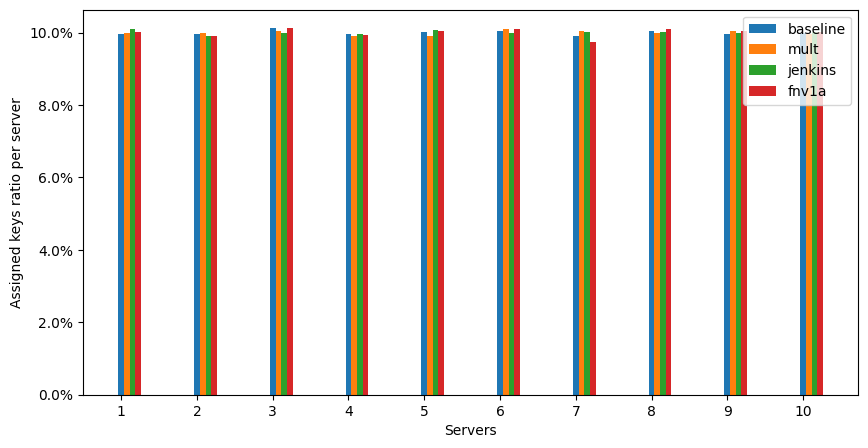

In [28]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

f, ax = plt.subplots(figsize=(10, 5))

ax.set_xticks([i+1 for i in range(SERVERS_COUNT)])
ax.yaxis.set_major_formatter(mtick.PercentFormatter())

bar_width = 0.075

for i, test in enumerate(tests):
    ax.bar([j + i*bar_width for j in range(1, SERVERS_COUNT + 1)],
           [test.buckets[j] / KEYS_COUNT * 100 for j in range(len(test.buckets))],
           width=bar_width,
           label=tests[i].name)

f.gca().set_xlabel('Servers')
f.gca().set_ylabel('Assigned keys ratio per server')
f.gca().legend()

# f.savefig("keys-distribution.png")

In [29]:
import scipy.stats as stats

Text(0, 0.5, 'std of keys distribution\n(normalized to keys count)')

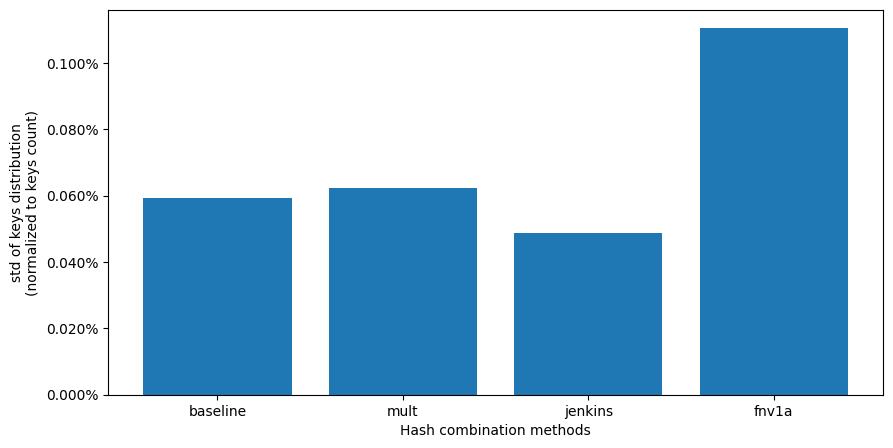

In [30]:
std_x = [t.name for t in tests]
std_y = [np.std(t.buckets) / KEYS_COUNT * 100 for t in tests]

f, ax = plt.subplots(figsize=(10, 5))

ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.bar(std_x, std_y)

f.gca().set_xlabel('Hash combination methods')
f.gca().set_ylabel('std of keys distribution\n(normalized to keys count)')

# f.savefig("std-distribution.png")

In [31]:
def print_stat(dist, name):
    print(f'### {name} ###')
    print(f'Mean: {np.mean(dist)}')
    print(f'Std: {np.std(dist)}')
    print(f'Mode: {stats.mode(dist)}')
    print(f'Skew: {stats.skew(dist)}')
    print()

for test in tests:
    print_stat(test.buckets, test.name)

### baseline ###
Mean: 10000.0
Std: 59.230059935812996
Mode: ModeResult(mode=np.int64(9921), count=np.int64(1))
Skew: 0.722766024393832

### mult ###
Mean: 10000.0
Std: 62.181990962014076
Mode: ModeResult(mode=np.int64(9903), count=np.int64(1))
Skew: -0.04425268175989889

### jenkins ###
Mean: 10000.0
Std: 48.67648302825503
Mode: ModeResult(mode=np.int64(9914), count=np.int64(1))
Skew: 0.19096007036005147

### fnv1a ###
Mean: 10000.0
Std: 110.4852931389513
Mode: ModeResult(mode=np.int64(9740), count=np.int64(1))
Skew: -1.0875881623165025



In [32]:
TEST_TRIES = 10
errors = [0 for _ in tests]
for i in range(TEST_TRIES):
    for test in tests:
        test.clear()

    for _ in range(KEYS_COUNT):
        # key_prefix = random.choice(KEYS_PREFIXES)
        # key_value = f'{key_prefix}:{random.randint(KEY_MIN_VALUE, KEY_MAX_VALUE)}'
        key_value = str(uuid4())
        ey = generate_key(key_value)

        for test in tests:
            test.add(key)

    for j in range(len(tests)):
        errors[j] += np.std(tests[j].buckets)/KEYS_COUNT

for i in range(len(errors)):
    errors[i] /= TEST_TRIES

Text(0, 0.5, 'error of keys')

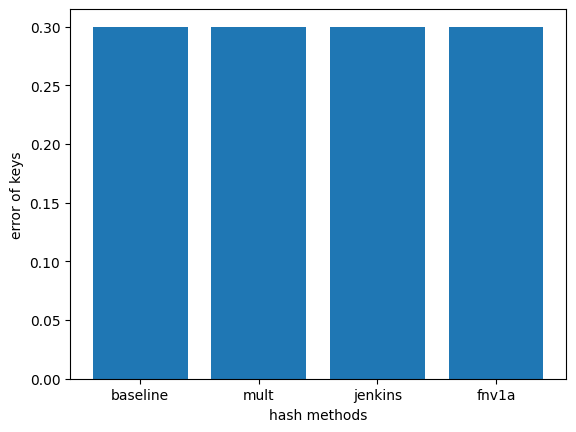

In [33]:
f, ax = plt.subplots()
ax.bar([t.name for t in tests], errors)

f.gca().set_xlabel('hash methods')
f.gca().set_ylabel('error of keys')